In [1]:
from dotenv import load_dotenv
from langchain_huggingface import HuggingFaceEmbeddings
import os
from langchain_groq import ChatGroq
load_dotenv
os.environ["HF_TOKEN"]=os.getenv("HF_TOKEN")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["GEMINI_API_KEY"] = os.getenv("GEMINI_API_KEY")

In [2]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")

C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
len(embeddings.embed_query("hi"))

768

In [4]:
from pinecone import Pinecone
os.environ["PINECONE_API_KEY"] = os.getenv("PINECONE_API_KEY")

pinecone_api_key = os.getenv("PINECONE_API_KEY")

In [5]:
pc = Pinecone(api_key=pinecone_api_key)

In [ ]:
from pinecone import ServerlessSpec ## you are not going to mange the server. and its managed by the cloud provider.
## create index
index_name = "cloud-db"

if not pc.has_index(index_name):
    pc.create_index(
    name=index_name,
    dimension=768,
    metric="dotproduct",
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    )
)

In [7]:
## loading the my db index
index = pc.Index(index_name)

In [8]:
from langchain_pinecone import PineconeVectorStore

vector_store = PineconeVectorStore(index=index, embedding=embeddings)

In [9]:
from langchain.schema import Document

document_1 = Document(
    page_content="AI tools are changing how students learn by adapting to their individual needs.",
    metadata={"source": "news"},
)

document_2 = Document(
    page_content="Just tested an AI tutor that gives instant feedback—crazy how far tech has come!",
    metadata={"source": "tweet"},
)

document_3 = Document(
    page_content="Personalized learning paths powered by LLMs can boost student performance.",
    metadata={"source": "blog"},
)

document_4 = Document(
    page_content="AI-based systems can detect when students are struggling and offer support.",
    metadata={"source": "article"},
)

document_5 = Document(
    page_content="LangChain’s new educational framework makes building AI tutors easier.",
    metadata={"source": "tweet"},
)

document_6 = Document(
    page_content="Every failure brings you one step closer to success.",
    metadata={"source": "tweet"},
)

document_7 = Document(
    page_content="OpenAI's latest model showcases improved reasoning and instruction-following.",
    metadata={"source": "research"},
)

document_8 = Document(
    page_content="Studying late-night boosts retention more than cramming in the morning.",
    metadata={"source": "study"},
)

document_9 = Document(
    page_content="Started using LangGraph to manage agent memory. Game changer!",
    metadata={"source": "tweet"},
)

document_10 = Document(
    page_content="Python remains the most popular language in data science.",
    metadata={"source": "article"},
)

documents = [document_1, document_2, document_3, document_4, document_5, document_6, document_7, document_8, document_9, document_10]

In [10]:
vector_store.add_documents(documents=documents)

['5c6ef5b4-85be-4e64-97dd-89087b1d9ae7',
 'e06c40bb-f32e-4bae-97ce-d091ece9c540',
 '75422262-1fe7-4e1c-abd2-85def7d1c9db',
 '83fd2dfc-7891-4ab9-bcb5-ea35b378c9c8',
 'aa873f11-c443-4d87-9a88-b31fe7b1fd10',
 '6433ef98-8a18-4d5b-953f-05357ce31953',
 'ca6b637d-4e06-4366-a502-fec3aa09da4f',
 '239dcd12-6340-4ae8-b989-617feb256799',
 'dd7c7958-f2a8-428e-9c88-730070b7d539',
 '01d61e62-2601-4630-ba29-58424c8f8200']

In [12]:
vector_store.similarity_search_with_score("Why python is the most popular language for Data science", k=2)

[(Document(id='01d61e62-2601-4630-ba29-58424c8f8200', metadata={'source': 'article'}, page_content='Python remains the most popular language in data science.'),
  0.893677711),
 (Document(id='dd7c7958-f2a8-428e-9c88-730070b7d539', metadata={'source': 'tweet'}, page_content='Started using LangGraph to manage agent memory. Game changer!'),
  0.278898239)]

In [22]:
retriever = vector_store.as_retriever(
    search_type = "similarity_score_threshold",
    search_kwargs={
        "k": 3,
        "score_threshold": 0.8
    }
    
    
)

In [23]:
retriever.invoke("Why python is the most popular language for Data science")

[Document(id='01d61e62-2601-4630-ba29-58424c8f8200', metadata={'source': 'article'}, page_content='Python remains the most popular language in data science.')]

In [24]:
from langchain_core.output_parsers import StrOutputParser
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

In [25]:
prompt.messages

[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]

In [27]:
from langchain_core.runnables import RunnablePassthrough

def format_docs(retriever_docs):
    context_text = "\n\n".join(doc.page_content for doc in retriever_docs)
    return context_text

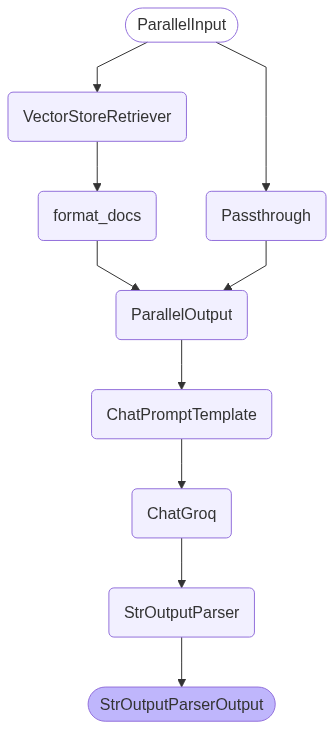

In [28]:
from IPython.display import display, Image
rag_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough()
    }
    | prompt
    | llm
    | StrOutputParser()
)

display(Image(rag_chain.get_graph().draw_mermaid_png()))

In [29]:
rag_chain.invoke("Why python is the most popular language for Data science")

"Python is the most popular language for data science, but the context doesn't specify why. Therefore, I don't know the specific reasons for its popularity."